In [35]:
import numpy as np
import matplotlib.pyplot as plt
import re
import os
from datetime import datetime
from scipy.optimize import curve_fit, fsolve
directory_path = 'Z:/Lab Data/Qudit_Ramsey_raw_data/Raw_data_PD/'

# Fixed frequency: 2π
def sine_function(t, A, phi, offset):
    return A * np.cos(2 * np.pi/10 * t + phi) + offset

def combined_decay(t, A, T2_G, T2_L):
    gaussian_decay = np.exp(-(t / T2_G)**2)
    lorentzian_decay = np.exp(-t / T2_L)
    return A * gaussian_decay * lorentzian_decay

def parse_filename(filename):
    pattern = (
        r"Ramsey_qubit_\[(\d+),(\d+),(\d+)\]_WaitTime(\d+)us_(\d{8})_(\d{4}).txt"
    )
    match = re.search(pattern, filename)
    # print(match)
    if match:
        m = int(match.group(1))
        F = int(match.group(2))
        mF = int(match.group(3))
        wait_time = int(match.group(4))
        date_str = match.group(5) + match.group(6)  # "YYYYMMDDHHMM"
        date_time = datetime.strptime(date_str, '%Y%m%d%H%M')
        return (m, F, mF, wait_time, date_time)
    else:
        return (None, None, None, None, None)

def search_files_by_transitions(directory, target_transition, target_date_times=None):
    wait_time_list = []
    raw_file_paths_list = []
    final_params = (None, None, None)
    for filename in os.listdir(directory):
        if filename.startswith('Ramsey_qubit'):
            (m, F, mF, wait_time, date_time) = parse_filename(filename)
            if None in (m, F, mF, wait_time, date_time):
                continue
            if (m, F, mF) == target_transition:
                if target_date_times and date_time not in target_date_times:
                    continue  # Skip if date_time is not in the target list
                final_params = (m, F, mF)
                file_path = os.path.join(directory, filename)
                raw_data_filenames = extract_raw_data_filenames(file_path)
                Z_drive_raw_data = 'Z:\\Lab Data\\Qudit_Ramsey_raw_data\\Raw_data\\'
                raw_data_filepaths = [os.path.join(Z_drive_raw_data, raw_filename) for raw_filename in raw_data_filenames]
                wait_time_list.append(wait_time)
                raw_file_paths_list.append(raw_data_filepaths)
    return wait_time_list, raw_file_paths_list, final_params

def extract_raw_data_filenames(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    raw_data_filenames_line = lines[-1].strip()
    raw_data_filenames = [
        name.strip().strip("'\"") for name in raw_data_filenames_line.strip('[]').split(',')
    ]
    return raw_data_filenames

if __name__ == "__main__":
    target_transition = (0, 2, 0)  # Replace with desired values
    # target_date_times = {datetime(2025, 3, 13, 18, 4),datetime(2025, 3, 13, 20, 49),datetime(2025, 3, 13, 21, 32)} 
    # target_date_times = {datetime(2025, 3, 12, 21, 43),datetime(2025, 3, 12, 23, 46),datetime(2025, 3, 13, 6, 49)} 
    target_date_times = {datetime(2025, 9, 25, 18, 2)} # new data without FNCS
    target_date_times = {datetime(2025, 9, 25, 18, 57)} # new data with FNCS
    # target_date_times = {datetime(2025, 9, 25, 20, 3), datetime(2025, 9, 26, 7, 36)} # new data with FNCS - fine scan
    # target_date_times = {datetime(2025, 10, 3, 15, 18)} # RFSoC data 50us steps
    target_date_times = {datetime(2025, 10, 8, 17, 59),datetime(2025, 10, 8, 17, 44)}
    wait_time_list, raw_file_paths_list, final_params = search_files_by_transitions(directory_path, target_transition, target_date_times)
    m, F, mF = final_params
    print(f"Parameters: m={m}, F={F}, mF={mF}")
    print("\nWait times and corresponding raw data file paths:")
    for wt, fp_list in zip(wait_time_list, raw_file_paths_list):
        print(f"\nWait time: {wt} us")
        
        for fp in fp_list:
            print(f"  {fp}")


Parameters: m=0, F=2, mF=0

Wait times and corresponding raw data file paths:

Wait time: 0 us
  Z:\\Lab Data\\Qudit_Ramsey_raw_data\\Raw_data_copied\\2025\\2025_10\\2025_10_08\\qudit_ramsey_scan_bused_195
  Z:\\Lab Data\\Qudit_Ramsey_raw_data\\Raw_data_copied\\2025\\2025_10\\2025_10_08\\qudit_ramsey_scan_bused_196
  Z:\\Lab Data\\Qudit_Ramsey_raw_data\\Raw_data_copied\\2025\\2025_10\\2025_10_08\\qudit_ramsey_scan_bused_197
  Z:\\Lab Data\\Qudit_Ramsey_raw_data\\Raw_data_copied\\2025\\2025_10\\2025_10_08\\qudit_ramsey_scan_bused_198
  Z:\\Lab Data\\Qudit_Ramsey_raw_data\\Raw_data_copied\\2025\\2025_10\\2025_10_08\\qudit_ramsey_scan_bused_199
  Z:\\Lab Data\\Qudit_Ramsey_raw_data\\Raw_data_copied\\2025\\2025_10\\2025_10_08\\qudit_ramsey_scan_bused_200
  Z:\\Lab Data\\Qudit_Ramsey_raw_data\\Raw_data_copied\\2025\\2025_10\\2025_10_08\\qudit_ramsey_scan_bused_201
  Z:\\Lab Data\\Qudit_Ramsey_raw_data\\Raw_data_copied\\2025\\2025_10\\2025_10_08\\qudit_ramsey_scan_bused_202
  Z:\\Lab Data\\Q

In [36]:
import numpy as np
import json

# --------------------------------
# Existing Functions (Unchanged)
# --------------------------------

def get_shelving_threshold(counts):
    data_sorted = np.sort(counts, axis=None)
    # Truncate outliers at the start and end
    data_sorted = data_sorted[100:-100]
    if len(data_sorted) > 1000:
        data_sorted = data_sorted[0:-1:round(data_sorted.size / (len(counts) * 0.0250167))]
    data_sorted_diff = data_sorted[1:-1] - data_sorted[0:-2]
    data_diff_max = max(data_sorted_diff)
    data_diff_maxind = np.argmax(data_sorted_diff)
    threshold = data_diff_max / 2 + data_sorted[data_diff_maxind]
    return threshold, data_sorted

def process_raw_data_files(raw_data_filepaths):
    arrays = []
    # Read and process the data from all raw data files
    for file_path in raw_data_filepaths:
        with open(file_path, 'r') as file:
            for line in file:
                data = json.loads(line)
                arrays.append(data[0]["0"])
    # Convert to numpy array
    hist_data = np.array(arrays)
    
    # Flatten the hist_data and compute shelving threshold
    flat_hist_data = hist_data.flatten()
    threshold, _ = get_shelving_threshold(flat_hist_data)

    # Prepare for further processing (3D array)
    arrays_3d = []
    for file_path in raw_data_filepaths[:]:
        arrays = []
        with open(file_path, 'r') as file:
            for line in file:
                data = json.loads(line)
                arrays.append(data[0]["0"][:])
        if len(arrays) == 0:
            arrays = list(np.full((100, 4), 40))  # fallback if no data
        arrays_3d.append(arrays)

    bool_array = np.array(arrays_3d) > threshold
    result_matrix = np.full(bool_array.shape, False, dtype=bool)
    # Identify the first occurrence of shelving (True value)
    for matrix_index in range(bool_array.shape[0]):
        for row_index in range(bool_array.shape[1]):
            true_indices = np.where(bool_array[matrix_index, row_index, :])
            if true_indices[0].size > 0:
                first_true_index = true_indices[0]
                # We exclude cases where the first-true index is 0 or 1
                if first_true_index[0] != 0:
                    result_matrix[matrix_index, row_index, first_true_index[0]] = True

    # Filter data and compute percentages used
    filtered_data_array = []
    percentage_data_used = []
    num_points = bool_array.shape[0]  # Determine the number of data points
    for i in range(num_points):
        data = result_matrix[i]
        rows_with_any_true = data.any(axis=1)
        filtered_data = data[rows_with_any_true]
        filtered_data_array.append(filtered_data)
        percentage_data_used.append(filtered_data.shape[0] / data.shape[0])

    # Compute ket data by averaging the filtered data
    def find_errors(num_SD, full_data_array, exp_num):
        upper_error = ((full_data_array + (num_SD**2 / (2 * exp_num))) /
                       (1 + (num_SD**2 / exp_num))) + np.sqrt(
                           ((full_data_array *
                             (1 - full_data_array) * num_SD**2) / exp_num) +
                           (num_SD**4 / (4 * exp_num**2))
                       ) / (1 + (num_SD**2 / exp_num))

        lower_error = ((full_data_array + (num_SD**2 / (2 * exp_num))) /
                       (1 + (num_SD**2 / exp_num))) - np.sqrt(
                           ((full_data_array *
                             (1 - full_data_array) * num_SD**2) / exp_num) +
                           (num_SD**4 / (4 * exp_num**2))
                       ) / (1 + (num_SD**2 / exp_num))

        return lower_error, upper_error

    ket_data = []
    exp_num_list = []
    for filtered_data in filtered_data_array:
        # Average across the 3rd dimension's index=2
        ket_data.append(np.mean(filtered_data, axis=0)[2])
        exp_num_list.append(len(filtered_data))
        
    lower_error, upper_error = find_errors(1, np.array(ket_data), np.array(exp_num_list))
    
    return ket_data, lower_error, upper_error


# ------------------------------------------------
# New Function Using Parallel Lists (NOT a dict)
# ------------------------------------------------
def process_all_wait_times_in_lists(wait_time_list, raw_file_paths_list):
    """
    Instead of passing a dictionary {wait_time: [file1, file2, ...]},
    we pass in two parallel lists:
      1) wait_time_list[i] 
      2) raw_file_paths_list[i]

    We will return four separate lists:
      - processed_wait_times[i]
      - ket_data_list[i]
      - lower_error_list[i]
      - upper_error_list[i]

    Each index i in these return lists corresponds to the same data set.
    """
    processed_wait_times = []
    ket_data_list = []
    lower_error_list = []
    upper_error_list = []
    
    # Iterate over each index in the parallel lists
    for i, wait_time in enumerate(wait_time_list):
        # Fetch corresponding raw data file paths
        raw_data_filepaths = raw_file_paths_list[i]

        # Process the raw data
        ket_data, lower_error, upper_error = process_raw_data_files(raw_data_filepaths)

        # Store results in the four lists
        processed_wait_times.append(wait_time)

        # ket_data is already a list of floats
        # lower_error and upper_error are arrays (same shape as ket_data)
        # The original code does:
        #   final_lower = ket_data - lower_error
        #   final_upper = upper_error - ket_data
        # so we replicate that logic
        ket_data_arr = np.array(ket_data)
        final_lower_error = np.abs(ket_data_arr - np.array(lower_error))
        final_upper_error = np.abs(np.array(upper_error) - ket_data_arr)

        ket_data_list.append(ket_data)
        lower_error_list.append(final_lower_error)
        upper_error_list.append(final_upper_error)

    return processed_wait_times, ket_data_list, lower_error_list, upper_error_list



(
    processed_wait_times, 
    ket_data_list, 
    lower_error_list, 
    upper_error_list
) = process_all_wait_times_in_lists(wait_time_list, raw_file_paths_list)

# Printing example output
print("\nProcessed Data in Parallel Lists:")
for wt, ket_vals, le_vals, ue_vals in zip(processed_wait_times, ket_data_list, lower_error_list, upper_error_list):
    print(f"\nWait Time: {wt} us")
    print(f"Ket Data (list): {ket_vals}")
    print(f"Lower Error (array): {le_vals}")
    print(f"Upper Error (array): {ue_vals}")


c:\Users\iamga\anaconda3\Lib\site-packages\numpy\_core\fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\iamga\anaconda3\Lib\site-packages\numpy\_core\_methods.py:139: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
C:\Users\iamga\AppData\Local\Temp\ipykernel_48968\320175720.py:72: RuntimeWarning: divide by zero encountered in divide
  upper_error = ((full_data_array + (num_SD**2 / (2 * exp_num))) /
C:\Users\iamga\AppData\Local\Temp\ipykernel_48968\320175720.py:73: RuntimeWarning: divide by zero encountered in divide
  (1 + (num_SD**2 / exp_num))) + np.sqrt(
C:\Users\iamga\AppData\Local\Temp\ipykernel_48968\320175720.py:76: RuntimeWarning: divide by zero encountered in divide
  (num_SD**4 / (4 * exp_num**2))
C:\Users\iamga\AppData\Local\Temp\ipykernel_48968\320175720.py:77: RuntimeWarning: divide by zero encountered in divide
  ) / (1 + (num_SD**2 / exp_num))
C:\Users\iamga\AppData\Local\Tem


Processed Data in Parallel Lists:

Wait Time: 0 us
Ket Data (list): [np.float64(0.0), np.float64(0.057692307692307696), np.float64(0.3125), np.float64(0.5227272727272727), np.float64(0.875), np.float64(1.0), np.float64(0.9333333333333333), np.float64(0.6666666666666666), np.float64(0.3877551020408163), np.float64(0.1111111111111111), np.float64(0.0196078431372549)]
Lower Error (array): [0.         0.0247511  0.0625     0.07496532 0.05551445 0.01818182
 0.04738605 0.0758689  0.06669755 0.03864734 0.01209304]
Upper Error (array): [1.78571429e-02 4.14419572e-02 7.01530612e-02 7.39552222e-02
 4.02083241e-02 1.11022302e-16 2.85454693e-02 6.81169598e-02
 7.11873466e-02 5.55555556e-02 3.05696652e-02]

Wait Time: 10 us
Ket Data (list): [np.float64(0.34), np.float64(0.10416666666666667), np.float64(0.037037037037037035), np.float64(0.08), np.float64(0.4146341463414634), np.float64(0.5925925925925926), np.float64(0.8863636363636364), np.float64(0.9347826086956522), np.float64(0.9333333333333333

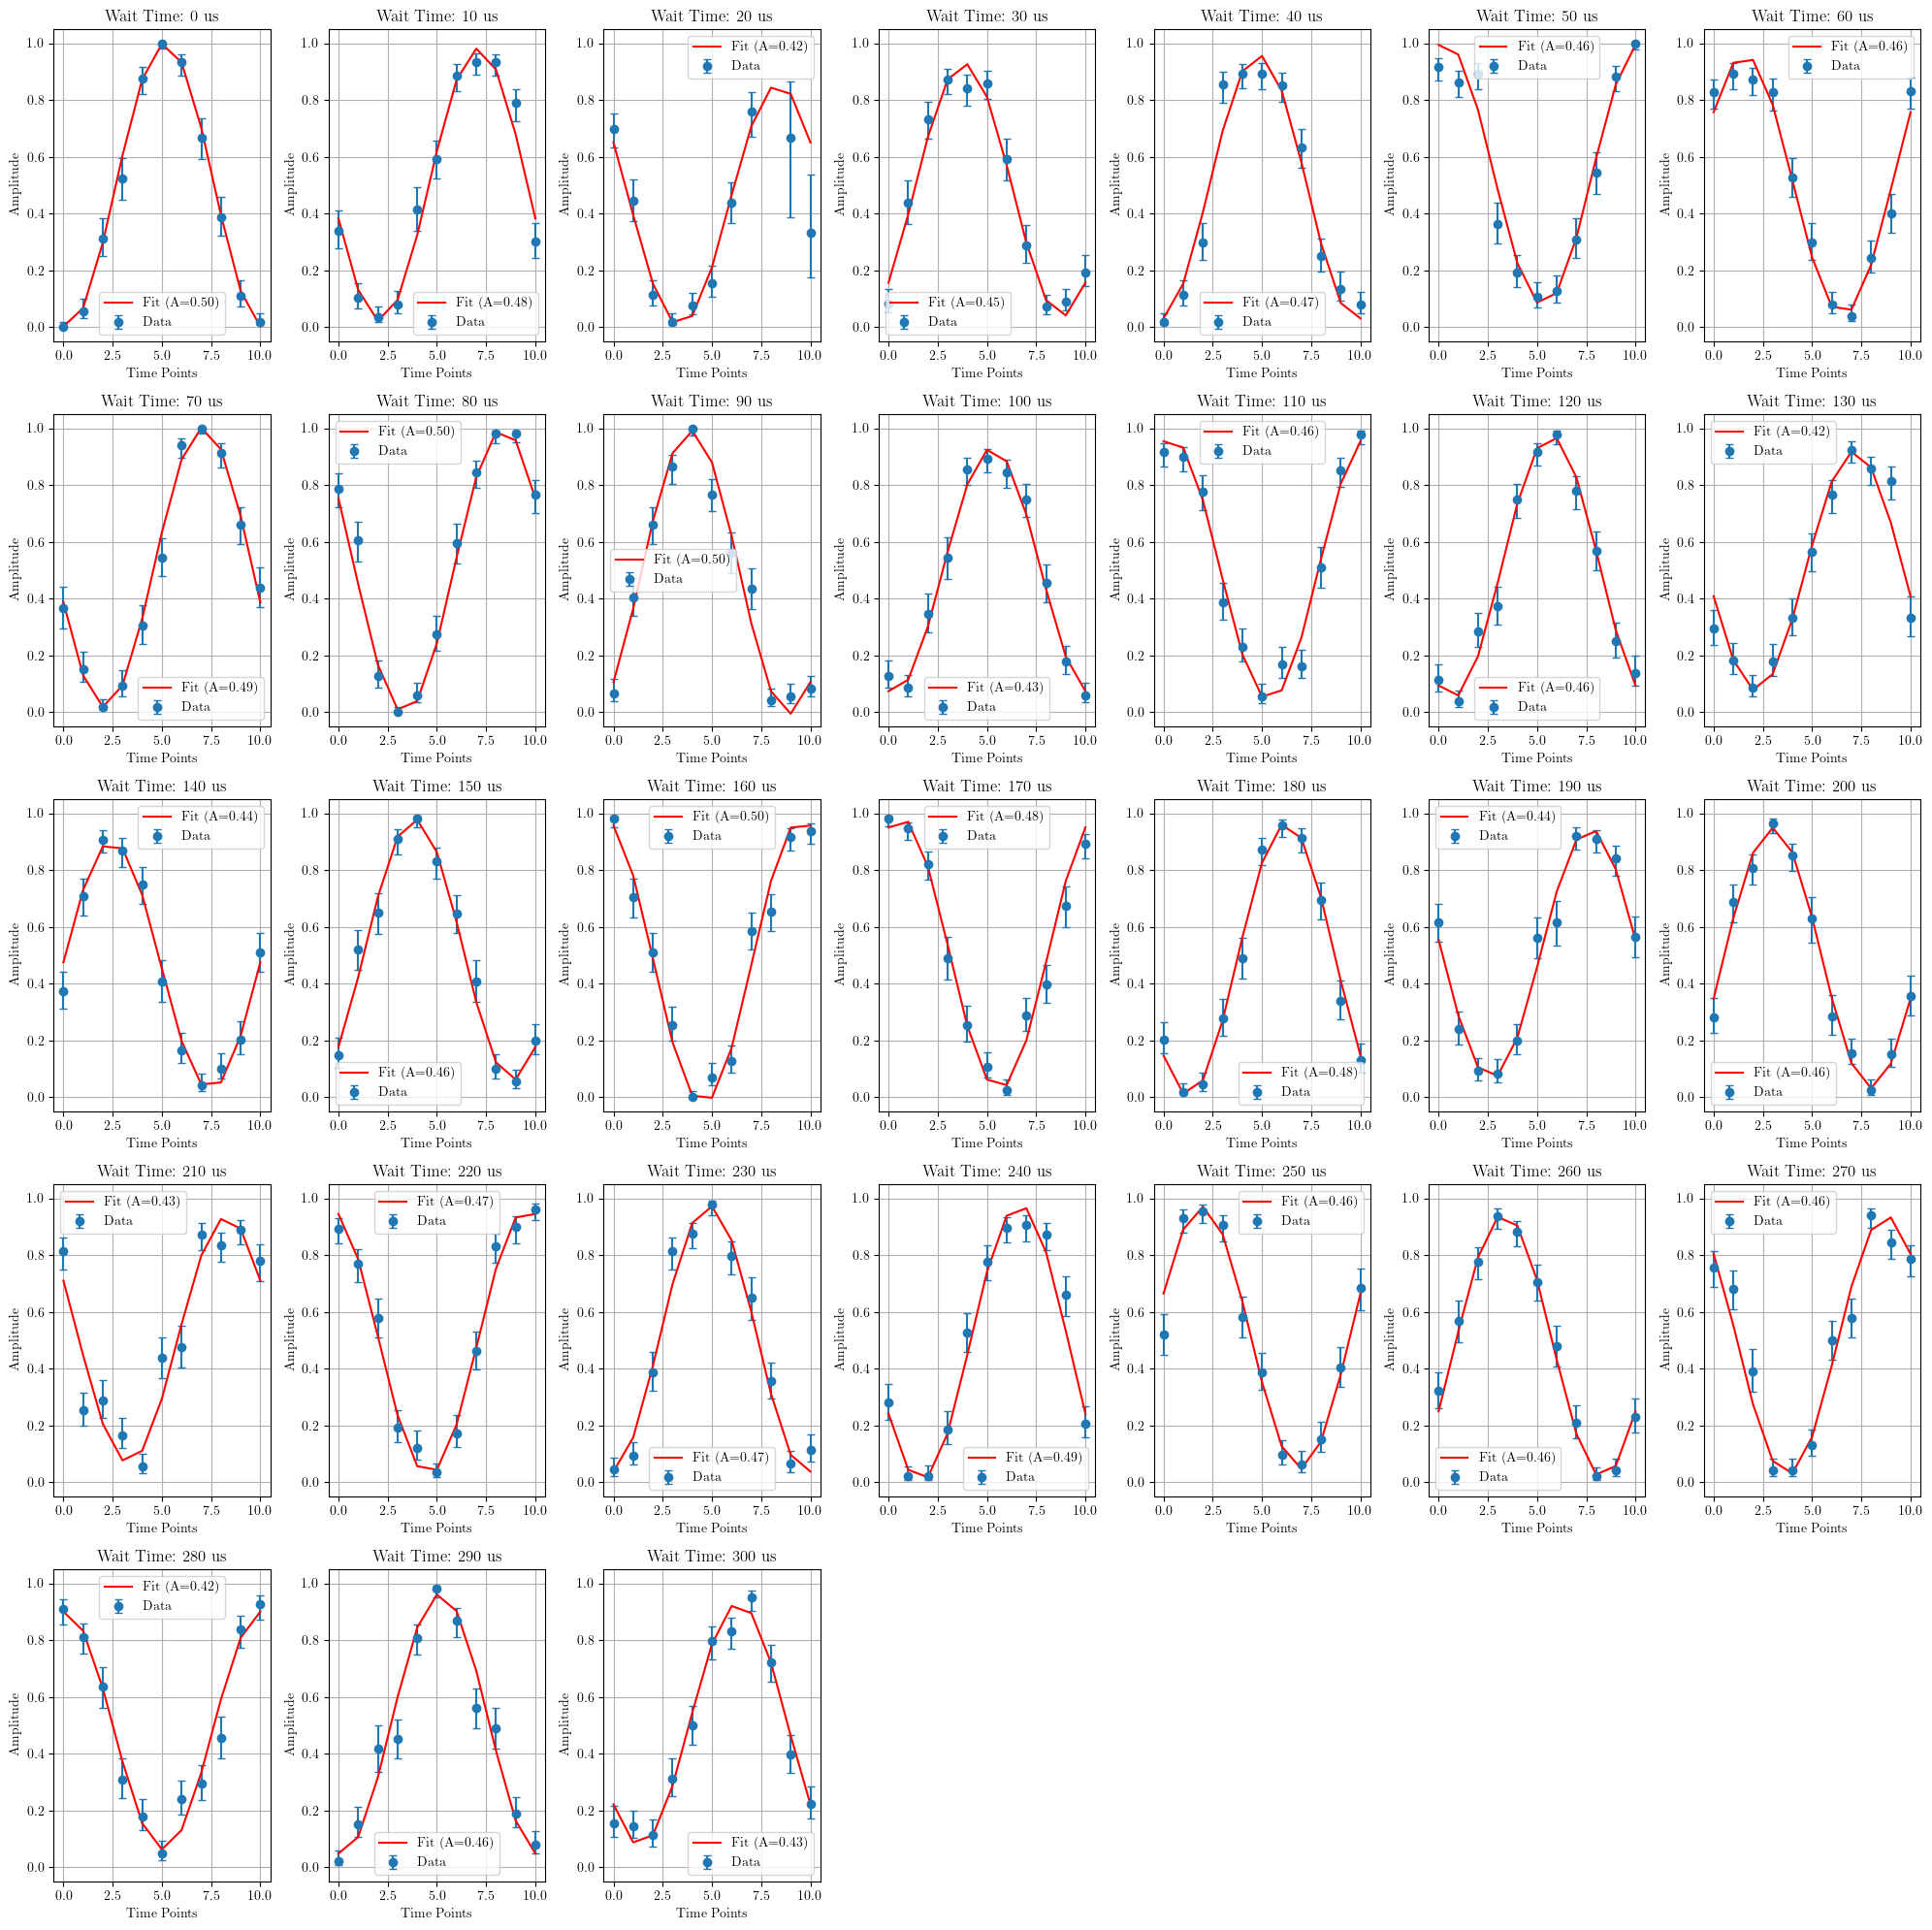


Fitted Results (Lists):
Wait Time: 0 us
  Params (A, phi, offset) = 0.500, 3.039, 0.500
  Amplitude (2*|A|) = 1.000 ± 0.013
  Phase = 3.039 ± 0.050
Wait Time: 10 us
  Params (A, phi, offset) = 0.480, 1.821, 0.502
  Amplitude (2*|A|) = 0.960 ± 0.033
  Phase = 1.821 ± 0.049
Wait Time: 20 us
  Params (A, phi, offset) = 0.424, 1.026, 0.431
  Amplitude (2*|A|) = 0.848 ± 0.058
  Phase = 1.026 ± 0.062
Wait Time: 30 us
  Params (A, phi, offset) = 0.445, -2.396, 0.484
  Amplitude (2*|A|) = 0.890 ± 0.039
  Phase = -2.396 ± 0.055
Wait Time: 40 us
  Params (A, phi, offset) = 0.466, -3.017, 0.493
  Amplitude (2*|A|) = 0.931 ± 0.032
  Phase = -3.017 ± 0.054
Wait Time: 50 us
  Params (A, phi, offset) = 0.462, -0.195, 0.540
  Amplitude (2*|A|) = 0.925 ± 0.031
  Phase = -0.195 ± 0.054
Wait Time: 60 us
  Params (A, phi, offset) = 0.457, -0.978, 0.502
  Amplitude (2*|A|) = 0.914 ± 0.037
  Phase = -0.978 ± 0.054
Wait Time: 70 us
  Params (A, phi, offset) = 0.492, 1.823, 0.510
  Amplitude (2*|A|) = 0.985 

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# # Fixed frequency: 2π
# def sine_function(t, A, phi, offset):
#     return A * np.cos(2 * np.pi/10 * t + phi) + offset

# def fit_sine_curve(ket_data, lower_error, upper_error):
#     if len(ket_data) == 5:
#         t = 2*np.arange(len(ket_data))
#     else:
#         t = np.arange(len(ket_data))
#     valid_indices = ~np.isnan(ket_data) & ~np.isnan(lower_error) & ~np.isnan(upper_error)
#     t_valid = t[valid_indices]
#     ket_data_valid = np.array(ket_data)[valid_indices]
#     lower_error_valid = np.array(lower_error)[valid_indices]
#     upper_error_valid = np.array(upper_error)[valid_indices]

#     sigma = (upper_error_valid + lower_error_valid) / 2.0
#     if np.any(sigma <= 0):
#         nonzero = sigma[sigma > 0]
#         replacement = np.min(nonzero) if len(nonzero) > 0 else 1.0
#         sigma[sigma <= 0] = replacement

#     initial_guess = [
#         (np.max(ket_data_valid) - np.min(ket_data_valid))/2,
#         0,
#         np.mean(ket_data_valid)
#     ]
#     try:
#         params, covariance = curve_fit(
#             sine_function,
#             t_valid,
#             ket_data_valid,
#             p0=initial_guess,
#             sigma=sigma,
#             absolute_sigma=True, maxfev=10000
#         )
#         if covariance is not None:
#             errors = np.sqrt(np.diag(covariance))
#             errors = [err if np.isfinite(err) else None for err in errors]
#         else:
#             errors = [None] * len(params)

#         return params, errors
#     except RuntimeError:
#         return None, None

def sine_function(t, A, phi, offset):
    return A * np.cos(2 * np.pi/10 * t + phi) + offset

def fit_sine_curve(ket_data, lower_error, upper_error):
    if len(ket_data) == 5:
        t = 2*np.arange(len(ket_data))
    else:
        t = np.arange(len(ket_data))
    valid_indices = ~np.isnan(ket_data) & ~np.isnan(lower_error) & ~np.isnan(upper_error)
    t_valid = t[valid_indices]
    ket_data_valid = np.array(ket_data)[valid_indices]
    lower_error_valid = np.array(lower_error)[valid_indices]
    upper_error_valid = np.array(upper_error)[valid_indices]

    sigma = (upper_error_valid + lower_error_valid) / 2.0
    if np.any(sigma <= 0):
        nonzero = sigma[sigma > 0]
        replacement = np.min(nonzero) if len(nonzero) > 0 else 1.0
        sigma[sigma <= 0] = replacement

    A0 = (np.max(ket_data_valid) - np.min(ket_data_valid))/2
    A0 = np.clip(A0, 0.0, 0.5)
    initial_guess = [A0, 0.0, np.mean(ket_data_valid)]

    try:
        params, covariance = curve_fit(
            sine_function,
            t_valid,
            ket_data_valid,
            p0=initial_guess,
            sigma=sigma,
            absolute_sigma=True,
            maxfev=10000,
            bounds=([0.0, -np.pi, -np.inf], [0.5, np.pi, np.inf])
        )
        if covariance is not None:
            errors = np.sqrt(np.diag(covariance))
            errors = [err if np.isfinite(err) else None for err in errors]
        else:
            errors = [None] * len(params)
        return params, errors
    except RuntimeError:
        return None, None


def fit_all_wait_times_to_sine_in_lists(wait_time_list,
                                        ket_data_list,
                                        lower_error_list,
                                        upper_error_list):
    fit_wait_times_list = []
    fit_params_list = []
    fit_amplitudes_list = []
    fit_amplitude_errors_list = []
    fit_phases_list = []
    fit_phase_errors_list = []
    
    for i in range(len(wait_time_list)):
        wt = wait_time_list[i]
        kd = ket_data_list[i]
        le = lower_error_list[i]
        ue = upper_error_list[i]
        
        if len(kd) > 4:
            params, errors = fit_sine_curve(kd, le, ue)
            if params is not None and errors is not None and errors[0] is not None:
                A, phi, offset = params
                amplitude = 2.0 * abs(A)
                amplitude_error = 2.0 * errors[0] if errors[0] is not None else None
                phase_error = errors[1]

                fit_wait_times_list.append(wt)
                fit_params_list.append(params)
                fit_amplitudes_list.append(amplitude)
                fit_amplitude_errors_list.append(amplitude_error)
                fit_phases_list.append(phi)
                fit_phase_errors_list.append(phase_error)
        else:
            fit_wait_times_list.append(wt)
            fit_params_list.append([None, None, None])
            fit_amplitudes_list.append(None)
            fit_amplitude_errors_list.append(None)
            fit_phases_list.append(None)
            fit_phase_errors_list.append(None)
    return (
        fit_wait_times_list,
        fit_params_list,
        fit_amplitudes_list,
        fit_amplitude_errors_list,
        fit_phases_list,
        fit_phase_errors_list
    )

def plot_sine_fits_in_lists(wait_time_list,
                            ket_data_list,
                            lower_error_list,
                            upper_error_list,
                            fit_wait_times_list,
                            fit_params_list):
    num_plots = len(wait_time_list)
    num_columns = 7
    num_rows = (num_plots + num_columns - 1) // num_columns
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, 4 * num_rows))
    axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]
    
    for i in range(num_plots):
        wt = wait_time_list[i]
        kd = ket_data_list[i]
        le = lower_error_list[i]
        ue = upper_error_list[i]
        
        t = np.arange(len(kd))
        ax = axes[i]
        ax.errorbar(
            t,
            kd,
            yerr=[abs(le), abs(ue)],
            fmt='o',
            label='Data',
            capsize=3
        )
        
        if wt in fit_wait_times_list:
            j = fit_wait_times_list.index(wt)
            A, phi, offset = fit_params_list[i]
            if A is not None:
                fit_curve = sine_function(t, A, phi, offset)
                ax.plot(t, fit_curve, color='red', label=f'Fit (A={A:.2f})')

        ax.set_title(f'Wait Time: {wt} us')
        ax.set_xlabel('Time Points')
        ax.set_ylim(-0.05, 1.05)
        ax.set_ylabel('Amplitude')
        ax.grid()
        ax.legend()
    
    for i in range(num_plots, len(axes)):
        fig.delaxes(axes[i])
    
    plt.tight_layout()
    plt.savefig('laser_noise_phase_scans.svg')
    plt.show()

(
    fit_wait_times_list,
    fit_params_list,
    fit_amplitudes_list,
    fit_amplitude_errors_list,
    fit_phases_list,
    fit_phase_errors_list
) = fit_all_wait_times_to_sine_in_lists(
    wait_time_list,
    ket_data_list,
    lower_error_list,
    upper_error_list
)

plot_sine_fits_in_lists(
    wait_time_list,
    ket_data_list,
    lower_error_list,
    upper_error_list,
    fit_wait_times_list,
    fit_params_list
)

print("\nFitted Results (Lists):")
for i, wt in enumerate(fit_wait_times_list):
    A, phi, offset = fit_params_list[i]
    amp = fit_amplitudes_list[i]
    amp_err = fit_amplitude_errors_list[i]
    phase = fit_phases_list[i]
    phase_err = fit_phase_errors_list[i]
    print(f"Wait Time: {wt} us")
    print(f"  Params (A, phi, offset) = {A:.3f}, {phi:.3f}, {offset:.3f}")
    print(f"  Amplitude (2*|A|) = {amp:.3f} ± {amp_err:.3f}")
    print(f"  Phase = {phase:.3f} ± {phase_err:.3f}")


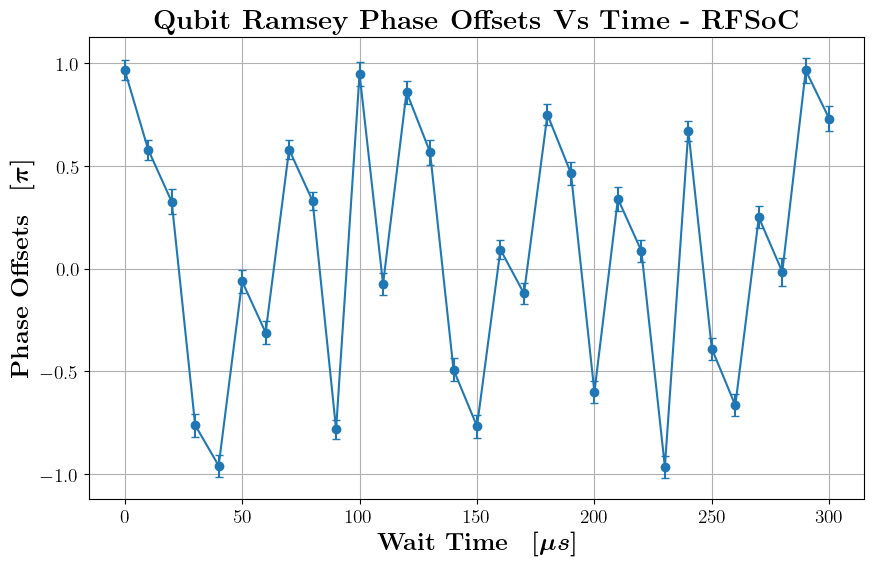

: 

In [ ]:
plt.figure(figsize=(10, 6))
# plt.plot(
#     fit_wait_times_list,
#     fit_phases_list)
plt.errorbar(
    fit_wait_times_list,
    np.array(fit_phases_list)/np.pi,
    yerr=fit_phase_errors_list,
    fmt='-o',
    capsize=3
)

plt.xlabel(r'\boldmath$\textbf{Wait Time}\quad [\mu s]$', fontsize=18)
plt.ylabel(r'\boldmath$\textbf{Phase Offsets}\quad [\pi]$', fontsize=18)
plt.title(r'\textbf{Qubit Ramsey Phase Offsets Vs Time - RFSoC}', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid()
plt.savefig('0_2_0_phase_offsets_for_laser_noise_with_RFSoC.png', dpi=300, bbox_inches="tight")
plt.show()

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import fsolve

# Fixed frequency: 2π
def sine_function(t, A, phi, offset):
    return A * np.cos(2 * np.pi/10 * t + phi) + offset

def combined_decay(t, A, T2_G, T2_L):
    gaussian_decay = np.exp(-(t / T2_G)**2)
    lorentzian_decay = np.exp(-t / T2_L)
    return A * gaussian_decay * lorentzian_decay

def fit_sine_curve(ket_data, lower_error, upper_error):
    if len(ket_data) == 5:
        t = 2*np.arange(len(ket_data))
    else:
        t = np.arange(len(ket_data))
    valid_indices = ~np.isnan(ket_data) & ~np.isnan(lower_error) & ~np.isnan(upper_error)
    t_valid = t[valid_indices]
    ket_data_valid = np.array(ket_data)[valid_indices]
    lower_error_valid = np.array(lower_error)[valid_indices]
    upper_error_valid = np.array(upper_error)[valid_indices]

    sigma = (upper_error_valid + lower_error_valid) / 2.0
    if np.any(sigma <= 0):
        nonzero = sigma[sigma > 0]
        replacement = np.min(nonzero) if len(nonzero) > 0 else 1.0
        sigma[sigma <= 0] = replacement

    initial_guess = [
        (np.max(ket_data_valid) - np.min(ket_data_valid))/2,
        0,
        np.mean(ket_data_valid)
    ]
    try:
        params, covariance = curve_fit(
            sine_function,
            t_valid,
            ket_data_valid,
            p0=initial_guess,
            sigma=sigma,
            absolute_sigma=True, maxfev=10000
        )
        if covariance is not None:
            errors = np.sqrt(np.diag(covariance))
            errors = [err if np.isfinite(err) else None for err in errors]
        else:
            errors = [None] * len(params)

        return params, errors
    except RuntimeError:
        return None, None

def fit_amplitude_decay(wait_times, amplitudes, errors):
    initial_guess = [
        float(np.max(amplitudes)),
        float(np.mean(wait_times)),
        float(np.mean(wait_times))
    ]
    try:
        params, pcov = curve_fit(
            combined_decay,
            wait_times,
            amplitudes,
            p0=initial_guess,
            sigma=errors,
            absolute_sigma=True,
            maxfev=10000
        )
        A, T2_G, T2_L = params
        return A, T2_G, T2_L, pcov
        # return params, pcov
    except RuntimeError:
        return None, None

def calculate_coherence_time(T2_G, T2_L):
    def decay_eq(t):
        return np.exp(-(t / T2_G)**2 - t / T2_L) - 1 / np.e
    t_coherence = fsolve(decay_eq, T2_G)
    return t_coherence[0]

def compute_partial_derivatives(T2_G, T2_L, t_eff):
    t = t_eff
    dF_dt = (2 * t) / T2_G**2 + 1 / T2_L
    dF_dT2_G = -2 * t**2 / T2_G**3
    dF_dT2_L = -t / T2_L**2
    dt_dT2_G = -dF_dT2_G / dF_dt
    dt_dT2_L = -dF_dT2_L / dF_dt
    return dt_dT2_G, dt_dT2_L

(
    fit_wait_times_list,
    fit_params_list,
    fit_amplitudes_list,
    fit_amplitude_errors_list,
    fit_phases_list,
    fit_phase_errors_list
) = fit_all_wait_times_to_sine_in_lists(
    wait_time_list,
    ket_data_list,
    lower_error_list,
    upper_error_list
)

A, T2_G, T2_L, pcov = fit_amplitude_decay(
    np.array(fit_wait_times_list),
    np.array(fit_amplitudes_list),
    np.array(fit_amplitude_errors_list)
)

if all(param is not None for param in [A, T2_G, T2_L, pcov]):
    sigma_A = np.sqrt(pcov[0, 0])
    sigma_T2_G = np.sqrt(pcov[1, 1])
    sigma_T2_L = np.sqrt(pcov[2, 2])
    cov_T2_G_T2_L = pcov[1, 2]
    print(f"Fitted Coherence Times:")
    print(f"A (Amplitude) = {A} ± {sigma_A}")
    print(f"T2_G (Gaussian) = {T2_G} ± {sigma_T2_G}")
    print(f"T2_L (Lorentzian) = {T2_L} ± {sigma_T2_L}")
    T2_eff = calculate_coherence_time(T2_G, T2_L)
    dt_dT2_G, dt_dT2_L = compute_partial_derivatives(T2_G, T2_L, T2_eff)
    sigma_T2_eff_squared = (
        (dt_dT2_G**2) * sigma_T2_G**2 +
        (dt_dT2_L**2) * sigma_T2_L**2 +
        2 * dt_dT2_G * dt_dT2_L * cov_T2_G_T2_L
    )
    sigma_T2_eff = np.sqrt(sigma_T2_eff_squared)
    print(f"Effective T2 Time: {T2_eff} ± {sigma_T2_eff}")
else:
    print("Fit failed or not enough data.")


Fitted Coherence Times:
A (Amplitude) = 1.0165392867953373 ± 0.013092126002835231
T2_G (Gaussian) = 2378.134659426966 ± 414.4611017927356
T2_L (Lorentzian) = 2180.5708032348407 ± 336.1246487501848
Effective T2 Time: 1411.9298265848709 ± 50.47388003839516


Fitted Coherence Times:
A (Amplitude) = 1.0165392867953373 ± 0.013092126002835231
T2_G (Gaussian) = 2378.134659426966 ± 414.4611017927356
T2_L (Lorentzian) = 2180.5708032348407 ± 336.1246487501848
Effective T2 Time: 1411.9298265848709 ± 50.47388003839516


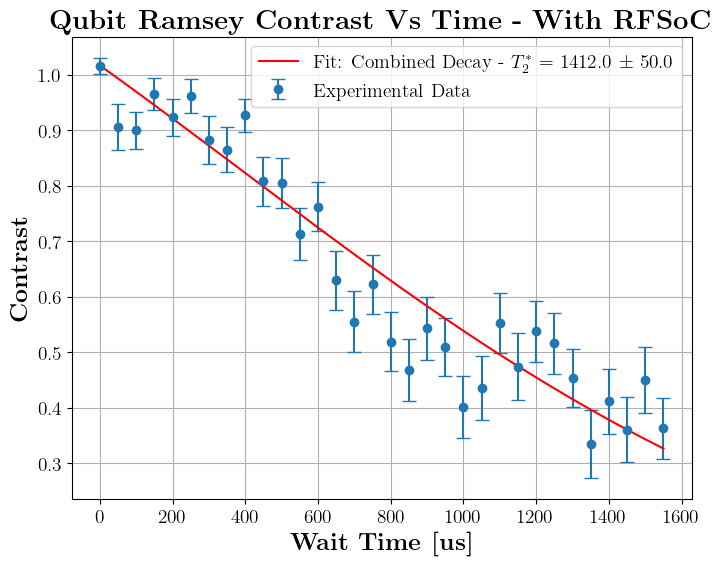

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Computer Modern']
rcParams['text.usetex'] = True

from scipy.optimize import curve_fit
from scipy.optimize import fsolve

# Fixed frequency: 2π
def sine_function(t, A, phi, offset):
    return A * np.cos(2 * np.pi/10 * t + phi) + offset

def combined_decay(t, A, T2_G, T2_L):
    gaussian_decay = np.exp(-(t / T2_G)**2)
    lorentzian_decay = np.exp(-t / T2_L)
    return A * gaussian_decay * lorentzian_decay

def fit_sine_curve(ket_data, lower_error, upper_error):
    if len(ket_data) == 5:
        t = 2*np.arange(len(ket_data))
    else:
        t = np.arange(len(ket_data))
    valid_indices = ~np.isnan(ket_data) & ~np.isnan(lower_error) & ~np.isnan(upper_error)
    t_valid = t[valid_indices]
    ket_data_valid = np.array(ket_data)[valid_indices]
    lower_error_valid = np.array(lower_error)[valid_indices]
    upper_error_valid = np.array(upper_error)[valid_indices]

    sigma = (upper_error_valid + lower_error_valid) / 2.0
    if np.any(sigma <= 0):
        nonzero = sigma[sigma > 0]
        replacement = np.min(nonzero) if len(nonzero) > 0 else 1.0
        sigma[sigma <= 0] = replacement

    initial_guess = [
        (np.max(ket_data_valid) - np.min(ket_data_valid))/2,
        0,
        np.mean(ket_data_valid)
    ]
    try:
        params, covariance = curve_fit(
            sine_function,
            t_valid,
            ket_data_valid,
            p0=initial_guess,
            sigma=sigma,
            absolute_sigma=True, maxfev=10000
        )
        if covariance is not None:
            errors = np.sqrt(np.diag(covariance))
            errors = [err if np.isfinite(err) else None for err in errors]
        else:
            errors = [None] * len(params)

        return params, errors    
    except RuntimeError:
        return None, None

def plot_fit(wait_times, amplitudes, errors, T2_G, T2_L, A, T2_eff, sigma_T2_eff):
    t_fit = np.linspace(min(wait_times), max(wait_times), 1000)
    amplitude_fit = combined_decay(t_fit, A, T2_G, T2_L)
    
    plt.figure(figsize=(8, 6))
    plt.errorbar(wait_times, amplitudes, yerr=errors, fmt='o', 
                 label='Experimental Data', capsize=5)
    plt.plot(t_fit, amplitude_fit, color='red',
             label=rf'Fit: Combined Decay - $T_2^*$ = {np.round(T2_eff)} ± {np.round(sigma_T2_eff)}')
    
    plt.xlabel(r'$\textbf{Wait Time [us]}$', fontsize=18)
    plt.ylabel(r'$\textbf{Contrast}$', fontsize=18)
    plt.title(r'$\textbf{Qubit Ramsey Contrast Vs Time - With RFSoC}$', fontsize=20)
    
    plt.tick_params(axis='both', which='major', labelsize=14)
    
    plt.legend(fontsize=14)
    
    plt.grid()
    
    plt.savefig('0_2_0_contrast_decay_for_laser_noise_with_RFSoC.png', dpi=300, bbox_inches="tight")
    plt.show()


def fit_amplitude_decay(wait_times, amplitudes, errors):
    initial_guess = [
        float(np.max(amplitudes)),
        float(np.mean(wait_times)),
        float(np.mean(wait_times))
    ]
    try:
        params, pcov = curve_fit(
            combined_decay,
            wait_times,
            amplitudes,
            p0=initial_guess,
            sigma=errors,
            absolute_sigma=True,
            maxfev=10000
        )
        A, T2_G, T2_L = params
        return A, T2_G, T2_L, pcov
    except RuntimeError:
        return None, None

def calculate_coherence_time(T2_G, T2_L):
    def decay_eq(t):
        return np.exp(-(t / T2_G)**2 - t / T2_L) - 1 / np.e
    t_coherence = fsolve(decay_eq, T2_G)
    return t_coherence[0]

def compute_partial_derivatives(T2_G, T2_L, t_eff):
    t = t_eff
    dF_dt = (2 * t) / T2_G**2 + 1 / T2_L
    dF_dT2_G = -2 * t**2 / T2_G**3
    dF_dT2_L = -t / T2_L**2
    dt_dT2_G = -dF_dT2_G / dF_dt
    dt_dT2_L = -dF_dT2_L / dF_dt
    return dt_dT2_G, dt_dT2_L

(
    fit_wait_times_list,
    fit_params_list,
    fit_amplitudes_list,
    fit_amplitude_errors_list,
    fit_phases_list,
    fit_phase_errors_list
) = fit_all_wait_times_to_sine_in_lists(
    wait_time_list,
    ket_data_list,
    lower_error_list,
    upper_error_list
)

A, T2_G, T2_L, pcov = fit_amplitude_decay(
    np.array(fit_wait_times_list),
    np.array(fit_amplitudes_list),
    np.array(fit_amplitude_errors_list)
)

if all(param is not None for param in [A, T2_G, T2_L, pcov]):
    sigma_A = np.sqrt(pcov[0, 0])
    sigma_T2_G = np.sqrt(pcov[1, 1])
    sigma_T2_L = np.sqrt(pcov[2, 2])
    cov_T2_G_T2_L = pcov[1, 2]
    print(f"Fitted Coherence Times:")
    print(f"A (Amplitude) = {A} ± {sigma_A}")
    print(f"T2_G (Gaussian) = {T2_G} ± {sigma_T2_G}")
    print(f"T2_L (Lorentzian) = {T2_L} ± {sigma_T2_L}")
    T2_eff = calculate_coherence_time(T2_G, T2_L)
    dt_dT2_G, dt_dT2_L = compute_partial_derivatives(T2_G, T2_L, T2_eff)
    sigma_T2_eff_squared = (
        (dt_dT2_G**2) * sigma_T2_G**2 +
        (dt_dT2_L**2) * sigma_T2_L**2 +
        2 * dt_dT2_G * dt_dT2_L * cov_T2_G_T2_L
    )
    sigma_T2_eff = np.sqrt(sigma_T2_eff_squared)
    print(f"Effective T2 Time: {T2_eff} ± {sigma_T2_eff}")
    plot_fit(fit_wait_times_list, fit_amplitudes_list, fit_amplitude_errors_list, T2_G, T2_L, A, T2_eff, sigma_T2_eff)
else:
    print("Fit failed or not enough data.")
